In [2]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle

In [3]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

### Dataset without 76 document

In [4]:
# imp.reload(classes)
# imp.reload(feature_utils)
# dataset=classes.Dataset(dir_name=dir_name,doc_indices=doc_indices,merged_str=merged_str)
# dataset.set_tf_params('lemma')
# dataset.set_tf_params('word')
# dataset.set_tf_params('char_wb')
# dataset.pack_dataset()
# dataset.pack_sent_per_paragraph()
# dataset.reshape(seq_len,step)
# dataset.dump_to_file("new.76")

### Load dataset

In [5]:
dataset=pickle.load( open( os.path.join(os.getcwd(),
                defines.PATH_TO_DFS,
                dir_name,
                "dataset_new.76"+
                ".p"),
                 "rb"))

In [11]:
vars(dataset.tf_params['lemma'])

{'tf_type': 'lemma',
 'stop_list': [],
 'dir_name': 'reparse',
 'suffix': '_no.stop',
 'tf': TfidfVectorizer(lowercase=False, min_df=5, stop_words=[]),
 'doc_indices': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 'per_word': True,
 'per_lemma': True,
 'analyzer': 'word',
 'features': array(['CBT', 'XXX', 'be', ..., 'תשלום', 'תשע', 'תת'], dtype=object)}

### Check retrieving the paragraph for cross-validation

In [ ]:
imp.reload(model_utils)
paragraph_column=dataset.get_paragraph([1], '15_15')
paragraph_column

In [ ]:
len(flatten(paragraph_column))

In [ ]:
demo_dataset.reshape(seq_len,step)


In [ ]:
demo_dataset.dump_to_file("no.76")

### Load splits of documents as were used for BERT

In [113]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

### Run demo cross-validation on CRF using 2 splits of 2x document per each

In [77]:
tmp_split={'0':{'test':[1],'train':[2]}, '1': {'test':[3],'train':[4]}}

In [47]:
demo_crf_pred=model_utils.prepared_cross_validate_crf(dataset, tmp_split, seq_len=seq_len, step=step)

crf_params not passed
0 split started for 1 train sequences...
0 split fit of 41 samples took 00:00:00
0 split predict took 00:00:00
1 split started for 1 train sequences...
1 split fit of 46 samples took 00:00:00
1 split predict took 00:00:00


In [48]:
demo_crf_pred

,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx
0,1,0,0,not_nar,not_nar,0.700490,0.299510,0
1,1,1,0,not_nar,not_nar,0.729828,0.270172,1
2,1,2,0,not_nar,not_nar,0.815574,0.184426,2
3,1,3,0,not_nar,not_nar,0.854764,0.145236,3
4,1,4,0,not_nar,not_nar,0.927013,0.072987,4
...,...,...,...,...,...,...,...,...
1290,3,117,1,not_nar,not_nar,0.998536,0.001464,677
1291,3,117,1,not_nar,not_nar,0.997413,0.002587,678
1292,3,117,1,not_nar,not_nar,0.991990,0.008010,679
1293,3,117,1,not_nar,not_nar,0.990673,0.009327,680


Split 0
              precision    recall  f1-score   support

      is_nar       0.43      0.13      0.20       256
     not_nar       0.58      0.88      0.70       357

    accuracy                           0.57       613
   macro avg       0.51      0.50      0.45       613
weighted avg       0.52      0.57      0.49       613

MySegEval init called
MySegEval init called
Split 1
              precision    recall  f1-score   support

      is_nar       0.29      0.87      0.44       102
     not_nar       0.97      0.63      0.76       580

    accuracy                           0.67       682
   macro avg       0.63      0.75      0.60       682
weighted avg       0.87      0.67      0.72       682

MySegEval init called
MySegEval init called


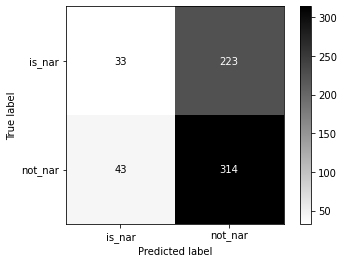

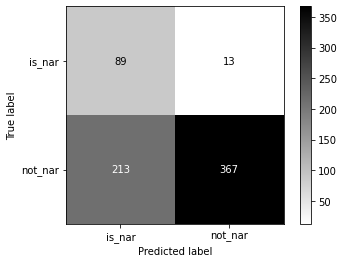

In [59]:
imp.reload(model_utils)
crf_scores, crf_dict, par_crf_scores, par_crf_dict = model_utils.get_report_from_splits(demo_crf_pred,"crf")

In [61]:
np.mean(crf_scores),np.mean(par_crf_scores)

(0.6041241618603934, 0.715661731054243)

### Add retriving strong features from CRF

In [20]:
imp.reload(model_utils)
my_crf = model_utils.CrfClassifier(crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True))

CrfClassifier>>>>>>init() called


In [21]:
my_crf.fit(dataset.get_x([1,2],'15_15'),dataset.get_y([1,2],'15_15'))

CrfClassifier(crf_model=CRF(all_possible_transitions=True, max_iterations=100),
              scorer=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']))

In [22]:
my_crf.predict(dataset.get_y([3,4],'15_15'))

CrfClassifier>>>>>>>predict() called


['is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',

In [50]:
my_crf.crf_model.state_features_
dataset.tf_params['lemma'].features

array(['CBT', 'XXX', 'be', ..., 'תשלום', 'תשע', 'תת'], dtype=object)

In [55]:
dataset.tf_params

{'lemma': <classes.TfParams at 0x2b832e7fae20>,
 'word': <classes.TfParams at 0x2b832e7faf40>,
 'char_wb': <classes.TfParams at 0x2b832e97e070>}

In [64]:
imp.reload(model_utils)
ft = model_utils.get_estimator_features(my_crf.crf_model,**dataset.tf_params)
ft

lemma
word
char_wb


,weight,label,attr,string
0,0.740766,is_nar,is_client,
1,0.359704,not_nar,+1:is_client,
2,0.351215,is_nar,+1:sent_pos_in_par,
3,0.346278,not_nar,-3:POSTAG_NN,
4,0.335047,is_nar,tfidf_lemma_221,אני
...,...,...,...,...
21807,-0.335047,not_nar,tfidf_lemma_221,אני
21808,-0.346278,is_nar,-3:POSTAG_NN,
21809,-0.351215,not_nar,+1:sent_pos_in_par,
21810,-0.359704,is_nar,+1:is_client,


In [35]:
len(dataset.tf_params['lemma'].features)

3215

In [38]:
ft.query('attr.str.contains("lemma")')

,weight,label,attr,string
4,0.335047,is_nar,tfidf_lemma_221,אדם
10,0.282368,is_nar,tfidf_lemma_704,אמפתיה
24,0.240351,is_nar,tfidf_lemma_748,אניחוזרת
29,0.229049,not_nar,tfidf_lemma_144,up
33,0.221999,is_nar,tfidf_lemma_1917,הדחה
...,...,...,...,...
21778,-0.221999,not_nar,tfidf_lemma_1917,הדחה
21782,-0.229049,is_nar,tfidf_lemma_144,up
21787,-0.240351,not_nar,tfidf_lemma_748,אניחוזרת
21801,-0.282368,not_nar,tfidf_lemma_704,אמפתיה


In [65]:
dataset.__class__.__name__

'Dataset'

In [71]:
dataset.doc_map[1].sent_list[0].text

'אז היום אנחנו נפגשים פה ב 123  אבל שבוע הבא בחמישי'

### Run cross-validation

In [32]:
imp.reload(model_utils)
cv_db_crf=model_utils.prepared_cross_validate_crf(dataset, cv_splits_loaded, seq_len=seq_len, step=step)

crf_params not passed
0 split started for 72 train sequences...
0 split fit of 229 samples took 00:00:27
0 split predict took 00:00:00
1 split started for 72 train sequences...
1 split fit of 267 samples took 00:00:26
1 split predict took 00:00:00
2 split started for 72 train sequences...
2 split fit of 231 samples took 00:00:27
2 split predict took 00:00:00
3 split started for 72 train sequences...
3 split fit of 280 samples took 00:00:26
3 split predict took 00:00:00
4 split started for 72 train sequences...
4 split fit of 258 samples took 00:00:27
4 split predict took 00:00:00
5 split started for 72 train sequences...
5 split fit of 280 samples took 00:00:25
5 split predict took 00:00:00
6 split started for 72 train sequences...
6 split fit of 227 samples took 00:00:26
6 split predict took 00:00:00
7 split started for 72 train sequences...
7 split fit of 284 samples took 00:00:27
7 split predict took 00:00:00
8 split started for 72 train sequences...
8 split fit of 310 samples took 

In [33]:
cv_db_crf

,crf_group,crf_par,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,crf_sent_idx
0,4,0,0,not_nar,not_nar,0.977135,0.022865,0
1,4,1,0,not_nar,not_nar,0.976613,0.023387,1
2,4,2,0,not_nar,not_nar,0.986431,0.013569,2
3,4,3,0,not_nar,not_nar,0.976959,0.023041,3
4,4,3,0,not_nar,not_nar,0.948269,0.051731,4
...,...,...,...,...,...,...,...,...
38776,79,171,9,not_nar,not_nar,0.888592,0.111408,3773
38777,79,172,9,not_nar,not_nar,0.996061,0.003939,3774
38778,79,172,9,not_nar,not_nar,0.999550,0.000450,3775
38779,79,172,9,not_nar,not_nar,0.999665,0.000335,3776


Split 0
              precision    recall  f1-score   support

      is_nar       0.65      0.46      0.54       781
     not_nar       0.85      0.93      0.89      2597

    accuracy                           0.82      3378
   macro avg       0.75      0.69      0.71      3378
weighted avg       0.80      0.82      0.81      3378

MySegEval init called
Split 1
              precision    recall  f1-score   support

      is_nar       0.62      0.42      0.50      1045
     not_nar       0.81      0.91      0.86      2911

    accuracy                           0.78      3956
   macro avg       0.72      0.66      0.68      3956
weighted avg       0.76      0.78      0.76      3956

MySegEval init called
Split 2
              precision    recall  f1-score   support

      is_nar       0.64      0.41      0.50       915
     not_nar       0.81      0.91      0.86      2498

    accuracy                           0.78      3413
   macro avg       0.72      0.66      0.68      3413
weight

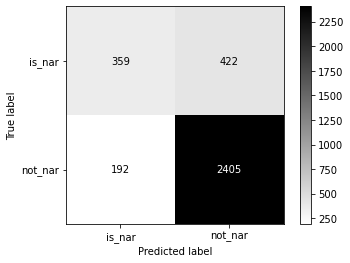

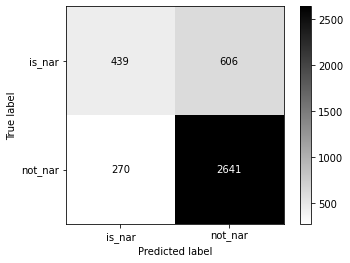

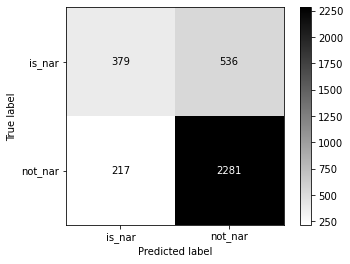

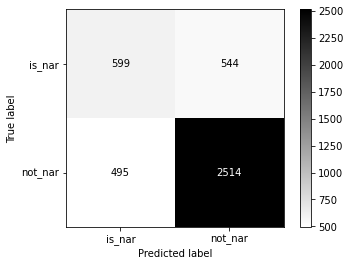

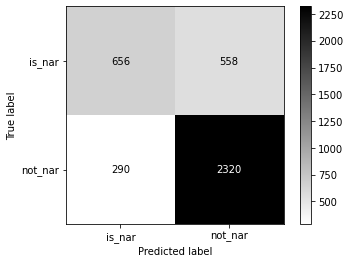

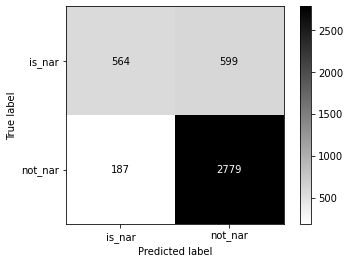

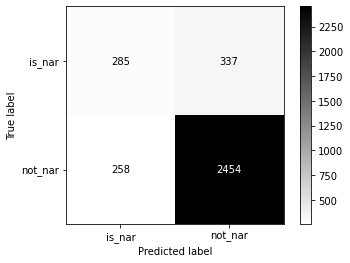

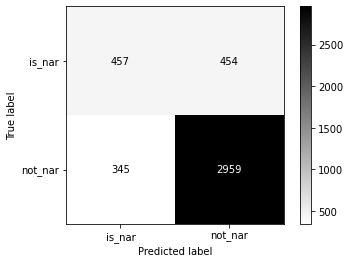

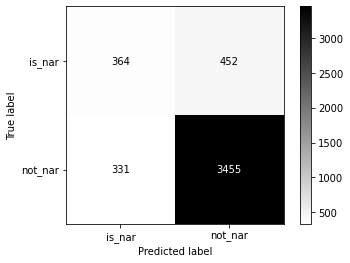

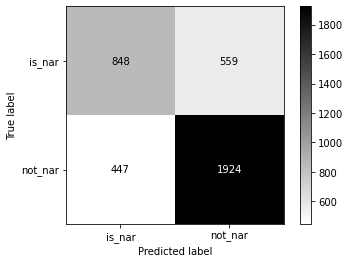

In [37]:
crf_scores, crf_dict = model_utils.get_report_from_splits(cv_db_crf,"crf")

In [38]:
np.mean(crf_scores),np.median(crf_scores)

(0.7824127344261238, 0.7826162220521802)

In [42]:
crf_dict['0'].keys()

dict_keys(['is_nar', 'not_nar', 'accuracy', 'macro avg', 'weighted avg', 'segeval'])

In [36]:
common_utils.save_db(cv_db_crf,dir_name,"crf.pred.new.76")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/crf.pred.new.76.csv,  index False


## Cross-validate BERT

## Create demo dataset

In [115]:
imp.reload(classes)
imp.reload(feature_utils)

demo_dataset=classes.Dataset(dir_name=dir_name,doc_indices=np.arange(1,81),merged_str=merged_str)
demo_dataset.set_tf_params('lemma')
demo_dataset.set_tf_params('word')
demo_dataset.set_tf_params('char_wb')
demo_dataset.pack_dataset()
demo_dataset.pack_sent_per_paragraph()
demo_dataset.reshape(seq_len,step)

Dataset init called
TfIdf lemma vocab size 3215
Sample of 3215 features
['CBT', 'XXX', 'be', 'fake', 'he', 'ill', 'make', 'mean', 'of', 'over', 'you', 'אאוט', 'אאוטסיידר', 'אב', 'אבא', 'אבחון', 'אבחן', 'אבטח', 'אביב', 'אבל']
['לגבי', 'לגיטימי', 'לגיטימציה', 'לגמרי', 'להיום', 'להיפך', 'להקה', 'לוואי', 'לוז', 'לום', 'לומד', 'לזה', 'לח', 'לחוץ', 'לחיץ', 'לחיצה', 'לחלוטין', 'לחם', 'לחץ', 'ליבן']
['CBT', 'בזמנו', 'הוכח', 'התחייב', 'חשד', 'לח', 'מעקב', 'סדר', 'פסיכולוגיה', 'שאמרת']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TdIdf lemma built
TfIdf word vocab size 5529
Sample of 5529 features
['123', 'CBT', 'XXX', 'be', 'fake', 'he', 'ill', 'make', 'mean', 'of', 'you', 'אאוט', 'אאוטסיידר', 'אבא', 'אבדוק', 'אבוא', 'אבחון', 'אביא', 'אביב', 'אבין']
['לגן', 'לגעת', 'לגרום', 'לגשר', 'לגשת', 'לדאוג', 'לדבר', 'לדברים', 'לדוגמא', 'לדוגמה', 'לדחוף', 'לדחות', 'לדייט', 'לדייטים', 'לדירה', 'לדמיין', 'לדעת', 'לדעתי', 'לדעתך', 'לדרוש']
['123', 'בינתיים', 'הגבול', 'הקליפ', 'חודשיים', 'לדחות', 'מבואס', 'מקרין', 'עליך', 'שהן']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TdIdf word built
TfIdf char_wb vocab size 33038
Sample of 33038 features
[' 12', ' 123', ' 123 ', ' CB', ' CBT', ' CBT ', ' X ', ' XX', ' XXX', ' XXX ', ' be', ' be ', ' fa', ' fak', ' fake', ' he', ' he ', ' i ', ' il', ' ill']
['ופט ', 'ופטי', 'ופטים', 'ופטימ', 'ופי', 'ופי ', 'ופיה', 'ופיה ', 'ופיי', 'ופיל', 'ופיל ', 'ופים', 'ופים ', 'ופיע', 'ופיעה', 'ופית', 'ופית ', 'ופך', 'ופך ', 'ופכ']
[' 12', ' ותמי', ' עזו', 'בדיד', 'הימי', 'ופים', 'יסר', 'מגלה ', 'סכמ', 'ריעו']
0 1 2 

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TdIdf char_wb built

Packing dataset...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80

Reshaping dataset: seq_len 15, step 15...
Doc 1 reshaped from 613 to 41
1
Doc 2 reshaped from 652 to 44
2
Doc 3 reshaped from 682 to 46
3
Doc 4 reshaped from 471 to 32
4
Doc 5 reshaped from 513 to 35
5
Doc 6 reshaped from 810 to 54
6
Doc 7 reshaped from 466 to 32
7
Doc 8 reshaped from 399 to 27
8
Doc 9 reshaped from 588 to 40
9
Doc 10 reshaped from 406 to 28
10
Doc 11 reshaped from 737 to 50
11
Doc 12 reshaped from 741 to 50
12
Doc 13 reshaped from 750 to 50
13
Doc 14 reshaped from 668 to 45
14
Doc 

In [116]:
demo_dataset.doc_map[1].get_y()

['not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',

In [100]:
tmp_split

{'0': {'test': [1], 'train': [2]}, '1': {'test': [3], 'train': [4]}}

In [ ]:
imp.reload(common_utils)
imp.reload(my_bert)
imp.reload(model_utils)
bert_pred=my_bert.prepared_cross_validate_bert(docs_map=demo_dataset,
                                                cv_splits=cv_splits_loaded,
                                                epoch=3,
                                                batch_size=512,
                                                dir_name=dir_name,
                                                file_prefix='new.76')

BertXYTransformer>>>>>>>init() called
BertDatasetransformer>>>>>>>init() called
BertDatasetransformer>>>>>>>init() called
0 split started...
BertDatasetransformer>>>>>>>concat() called
BertDatasetransformer>>>>>>>transform() called for 72 docs


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


y labels are
 BertDatasetransformer>>>>>>>transform() done for 35403 samples, labels are [0 1]
BertDatasetransformer>>>>>>>concat() called
BertDatasetransformer>>>>>>>transform() called for 8 docs
y labels are
 BertDatasetransformer>>>>>>>transform() done for 3378 samples, labels are [0 1]


Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67648183 1.91657644]

 Epoch 1 / 3
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.644

Validation Loss: 0.559

 Epoch 2 / 3
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.595

Validation Loss: 0.554

 Epoch 3 / 3
  Batch    50  of     70.


In [119]:
bert_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par
0,4,0,0,0,0.735761,0.264239,0,0
1,4,0,0,0,0.809237,0.190763,1,1
2,4,0,0,0,0.830174,0.169826,2,2
3,4,0,0,0,0.627892,0.372108,3,3
4,4,0,0,0,0.656868,0.343132,4,3
...,...,...,...,...,...,...,...,...
38776,79,9,0,0,0.795311,0.204689,3773,171
38777,79,9,0,0,0.860838,0.139162,3774,172
38778,79,9,0,0,0.875573,0.124427,3775,172
38779,79,9,0,0,0.865315,0.134685,3776,172


Split 0
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2597
           1       0.53      0.52      0.52       781

    accuracy                           0.78      3378
   macro avg       0.69      0.69      0.69      3378
weighted avg       0.78      0.78      0.78      3378

MySegEval init called
MySegEval init called
Split 1
              precision    recall  f1-score   support

           0       0.84      0.78      0.80      2911
           1       0.48      0.58      0.52      1045

    accuracy                           0.72      3956
   macro avg       0.66      0.68      0.66      3956
weighted avg       0.74      0.72      0.73      3956

MySegEval init called
MySegEval init called
Split 2
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2498
           1       0.54      0.53      0.53       915

    accuracy                           0.75      3413
   macro avg    

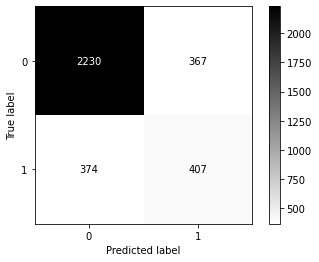

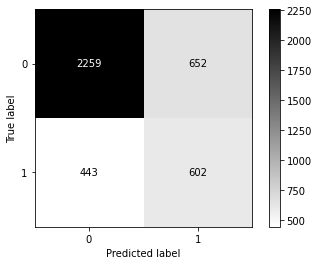

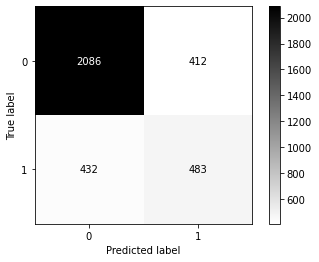

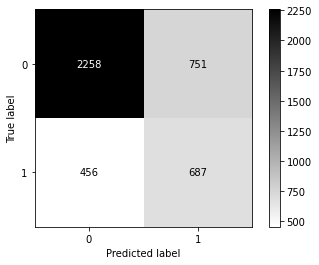

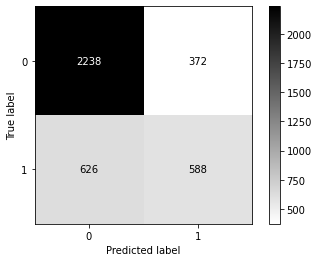

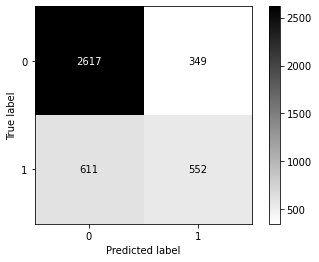

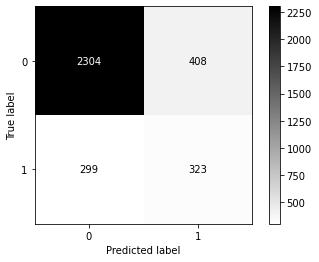

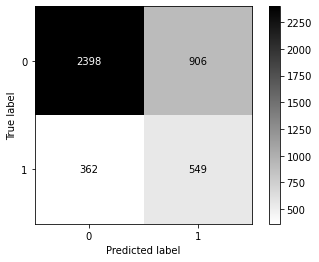

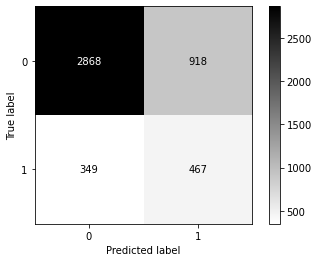

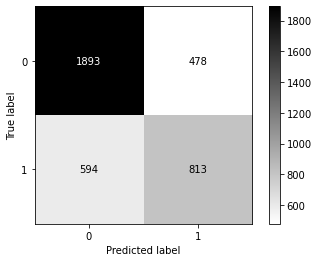

In [120]:
imp.reload(model_utils)
bert_scores, bert_dict, bert_par_scores, bert_par_dict = model_utils.get_report_from_splits(bert_pred,"bert")

In [123]:
np.mean(bert_par_scores),np.mean(bert_scores)

(0.7475449243268779, 0.744586282319846)

Remove 76 from splits

In [ ]:
crf_scores, crf_dict = model_utils.get_report_from_splits(cv_db_crf,"crf")

In [ ]:
crf_dict


In [ ]:
crf_scores,np.mean(crf_scores)

In [ ]:
worst_split=np.argmin(crf_scores)
worst_split

In [ ]:
f1={}
f1['is_nar']=[]
f1['not_nar']=[]
for label in f1.keys():
    for key,val in crf_dict.items():
        f1[label].append(val[label]['f1-score'])

In [ ]:
for k,v in f1.items():
    print(k,np.mean(v))

In [ ]:
colors=['r','b']
linestyle=['dashed','solid']

In [ ]:
from matplotlib import pyplot as plt
for y, c, st in zip(f1.keys(), colors,linestyle):
    data=f1[y]
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c,linestyle=st,label=y)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
plt.legend()
plt.ylabel('f-1 score') #set the label for y axis
plt.xlabel('fold index') #set the label for x-axis
plt.title('f-1 score per label') #set the title of the graph
plt.show() #display the graph

In [ ]:
f1

### Try single example

### Search parameters on prepared dataset with prepared splits (same as for BERT)

In [ ]:
dataset  = classes.Dataset(dir_name=dir_name,doc_indices=doc_indices,merged_str=merged_str)
dataset_loaded=pickle.load( open( os.path.join(dataset.path,"dataset_full.p"), "rb" ) )

In [ ]:
imp.reload(model_utils)
imp.reload(classes)

X,y,g,_ =  model_utils.get_X_y_by_doc_indices(dataset, doc_indices, seq_len, step)

In [ ]:
X[0]

In [ ]:
doc_indices

In [ ]:
cv_splits_loaded['0'].keys()

In [ ]:
type(cv_splits_loaded)

In [ ]:
imp.reload(classes)
cv_split_classes = []
for key,val in cv_splits_loaded.items():
    cv_split_classes.append(classes.Split(val['train'],val['test']))
cv_split_classes

In [ ]:
imp.reload(model_utils)
gsf = model_utils.GroupSplitFold(n_splits=len(cv_split_classes),prepared_splits=cv_split_classes)

for tr,ts in gsf.split():
    print(ts)

In [ ]:
imp.reload(model_utils)
my_crf = model_utils.CrfClassifier(crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True))

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed)

### First interation of best params

In [ ]:
params={}

In [ ]:
params[0]= {'algorithm': ['lbfgs'],
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
        'min_freq': np.arange(1, 8, 2)}


In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed,**params[0])

In [ ]:
vars(my_crf)

### Use f1_score + WinPR for parameters search

In [ ]:
imp.reload(classes)
mixed_scorer = classes.MyScorer(window_size=40)

In [ ]:
def score_func(y_true,y_pred):
    win_score = win_f1.score_func(y_true,y_pred)
    label_score = metrics.flat_f1_score(y_true,y_pred)
    print("winPR {} label {}".format(win_score,label_score))
    mixed_score = np.average(a=[win_score,label_score],weights=[0.5,0.5])
    return mixed_score

In [ ]:
y=[[1,1],[0,0]]
y_p=[[1,0],[0,0]]
score_func(y,y_p)

In [ ]:
crf_mixed_score=model_utils.CrfClassifier(
                crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True),
#                 scorer=score_func)
    scorer= mixed_scorer.score_func)

In [ ]:
vars(crf_mixed_score)

In [ ]:
X_demo,y_demo,g_demo,_ =  model_utils.get_X_y_by_doc_indices(demo_reloaded_dataset, [1,2], seq_len, step)

In [ ]:
imp.reload(model_utils)
imp.reload(feature_utils)
imp.reload(classes)
gsf_demo=model_utils.GroupSplitFold(n_splits=2, n_groups=1)
for tr,ts in gsf_demo.split(X=[1,2],groups=[1,2]):
    print(ts,tr)

In [ ]:
crf_mixed_score.find_best_params(X=X_demo,y=y_demo,groups=g_demo,cv=gsf_demo,random_state=seed,**params[0])

<b>put aside mixed measure</b>

In [ ]:
params[1]= {'algorithm': ['lbfgs'],
        'c1': np.arange(0.45,0.49,0.01),
        'c2': np.arange(0.008,0.01,0.001),
        'min_freq': np.arange(4, 7, 1)}

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed,**params[1])

In [ ]:
params[4]= {'algorithm': ['lbfgs'],
        'c1': np.arange(0.459,0.461,0.001),
        'c2': np.arange(0.0069,0.0072,0.0001),
        'min_freq': [5]}

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed,**params[4])

In [ ]:
params[5]= {'algorithm': ['lbfgs'],
        'c1': scipy.stats.expon(scale=0.459),
        'c2': scipy.stats.expon(scale=0.0071),
        'min_freq': [5]}

In [ ]:
my_crf.rs[4].best_score_

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed,**params[5])

In [ ]:
common_utils.dump_to_file(my_crf.rs[4].best_params_,"crf.rs.params.793")

### Cross-validate CRF on found best parameters

In [ ]:
imp.reload(model_utils)
cv_db_best_params = pd.DataFrame()
cv_db=pd.DataFrame()
cv_db_best_params=model_utils.prepared_cross_validate_crf(cv_db,dataset, cv_splits_loaded, seq_len, step,**my_crf.rs[4].best_params_)

In [ ]:
crf_scores_best, crf_dict_best = model_utils.get_report_from_splits(cv_db_best_params,"crf")

In [ ]:
crf_scores_best,np.mean(crf_scores_best)

In [ ]:
common_utils.save_db(cv_db_best_params,dir_name,"cv_crf_best_params.78")

### Try WinPR score

In [ ]:
imp.reload(classes)
wd=classes.WinPR(40)

def score_func(x):
    return wd.score_func(x['crf_true'].tolist(),x['crf_predicted'].tolist())

cv_db_crf.groupby('crf_group').apply(score_func)

In [ ]:
imp.reload(model_utils)
imp.reload(classes)
my_crf = model_utils.CrfClassifier(crf_model=CRF(
                max_iterations=100,
                all_possible_transitions=True),
                scorer=wd.score_func)

In [ ]:
params_winpr= {'algorithm': ['lbfgs'],
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
        'min_freq': np.arange(1, 8, 2)}

In [ ]:
my_crf.find_best_params(X=X,y=y,groups=g,cv=gsf,random_state=seed,**params_winpr)

## Calculate F1 for paragraphs

In [ ]:
imp.reload(classes)
dataset_par  = classes.Dataset(dir_name=dir_name,doc_indices=doc_indices,merged_str=merged_str)

### Copy docs map from old dataset to a new one that has implemented get_paragpraph()

In [ ]:
dataset_par.doc_map = dataset.doc_map.copy()

In [ ]:
vars(dataset_par)

### Add paragraph index to result database

In [ ]:
def add_paragraph(x):
    doc_idx=x['crf_group'].unique()
    dataset_par.get_paragraph([doc_idx],'')

In [ ]:
cv_db_crf.groupby('crf_group').apply(add_paragraph)

In [ ]:
dataset

In [ ]:
crf_try = CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
        ).fit(X_train, y_train)

In [ ]:
y_pred=crf_try.predict(X_test)

In [ ]:
feature_utils.get_prediction_report(flatten(y_test), flatten(
                y_pred), crf.classes_)

### Define static parameters for data

In [ ]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
ens_crf_db_name   = 'ensemble_crf_cv_db_all'
ens_lg_db_name = 'ensemble_lg_cv_db_all'
cv_crf_bert_name = 'cv_crf_bert_all'
cv_split_name='cv_splits_10'
per_par=True
seq_len=3
step=3
test_doc_num=8
n_splits=10
seed=42

### Load docs map

In [ ]:
imp.reload(common_utils)
docs_map=common_utils.get_docs_map(dir_name,docs_map_name,per_par,seq_len,step)

In [ ]:
imp.reload(model_utils)
my_crf=model_utils.CrfClassifier(crf)
# my_crf.find_best_params(X=x_tr,y=y_tr,groups=g_tr)

In [ ]:
my_crf.predict_on_best_params(0,X=x_ts,y=y_ts)

### Use same splits as for CRF & BERT (10 x 10)

In [ ]:
x=np.arange(1,81)
cv_splits_10=model_utils.get_test_train_splits(x,test_doc_num,n_splits,seed)
cv_splits_10

In [ ]:
imp.reload(model_utils)
cv_splits=model_utils.get_test_train_splits(doc_indices=doc_indices,test_doc_num=2,n_splits=2,seed=42)
cv_splits

In [ ]:
n_splits=10
gsf = model_utils.GroupSplitFold(n_splits=n_splits, n_groups=test_doc_num)

for tr,ts in gsf.split(X=x, groups=x, seed=seed):
    print(ts)

In [ ]:
imp.reload(classes)
dataset.get_x([1,3],'15_15')

In [ ]:
X,y,groups=model_utils.get_X_y_by_doc_indices(docs_map,list(docs_map.keys()),seq_len,step)

In [ ]:
tot_len=0
check=X
for l in check:
    if isinstance(l,list):
        tot_len+=len(check)
tot_len

In [ ]:
rs = {}

In [ ]:
vars(dataset.doc_map[1])

In [ ]:
global iterr

In [ ]:
def increment_iter():
    global iterr
    iterr+=1
    print('шtter {}'.format(iterr))

In [ ]:
%%time
# define fixed parameters and parameters to search
increment_iter()
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True,
    algorithm='lbfgs'
)
c1_param_range = np.arange(0.798,0.802,0.001)
c2_param_range = np.arange(0.0078,0.0082,0.0001)

params_space = {
    'c1': c1_param_range,
    'c2': c2_param_range,
    'min_freq': np.arange(1,4,1),
#      'epsilon':scipy.stats.expon(scale=0.00005),
#      'delta':scipy.stats.expon(scale=0.00005)
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search

rs[iterr] = GridSearchCV(crf, params_space,
                        cv=gsf,
                        verbose=3,
                        n_jobs=-1,
                        scoring=f1_scorer)

rs[iterr].fit(X=X, y=y,groups=groups)

In [ ]:
# grid search
print('best params:', rs[iterr].best_params_)
print('best CV score:', rs[iterr].best_score_)
print('model size: {:0.2f}M'.format(rs[iterr].best_estimator_.size_ / 1000000))

In [ ]:
rs[0].best_params_,rs[0].best_score_

In [ ]:
imp.reload(common_utils)
common_utils.save_best_params(rs[iterr].best_params_, rs[iterr].best_score_,dir_name)

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
import json
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d.%m_%H:%M")
print("date and time =", dt_string)
score="{:.3f}".format(rs.best_score_).lstrip('0')
score
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"{}_{}_best_params.json".format(score,dt_string))

best_params_pyth = common_utils.convert_to_python_types(rs.best_params_)
json_path
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)

In [ ]:
json_path